### Libraries

In [105]:
import numpy as np,pandas as pd
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,auc
from sklearn.metrics import confusion_matrix,accuracy_score,r2_score,mean_squared_error
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.preprocessing import LabelEncoder 
import datetime as dt

In [110]:
test=pd.read_csv('patient_monthwise_revenue_test.csv')
train=pd.read_csv('patient_monthwise_revenue_train.csv')
test_p=pd.read_csv('physio_diagnosis_test.csv')
train_p=pd.read_csv('physio_diagnosis_train.csv')
train_cl=pd.read_csv('patient_train_classified.csv')
train_ph=pd.read_csv('physio_appts_train.csv')

#

/home/rajat/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/rajat/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### PREPROCESSING

In [112]:
train_cl.columns=['patient_id','Bucket','revenue']
train_cl.head()

,patient_id,Bucket,revenue
0,400061,Med,1200.0
1,25535,High,25150.0
2,409013,Med,4480.0
3,164585,Low,500.0
4,56960,Low,500.0


In [113]:
train.drop('revenue',axis=1,inplace=True)
train=pd.merge(train,train_cl,on='patient_id').drop(['Bucket'],axis=1)

In [114]:
train.drop(['Unnamed: 20','Unnamed: 21'],axis=1,inplace=True)
test.drop(['Unnamed: 18','Unnamed: 19'],axis=1,inplace=True)
train_p.drop(['Unnamed: 7','Unnamed: 8'],axis=1,inplace=True)
test_p.drop(['Unnamed: 6','Unnamed: 7'],axis=1,inplace=True)

In [115]:
train.service_name.fillna('None',inplace=True)
test.service_name.fillna('None',inplace=True)
train.gender.fillna('None',inplace=True)
test.gender.fillna('None',inplace=True)
train.diagnosis.fillna('None',inplace=True)
test.diagnosis.fillna('None',inplace=True)


In [119]:
train=train[train.visits_required!=0]

In [120]:
test.shape,train.shape,train_p.shape,test_p.shape,train_cl.shape,train_ph.shape

((55329, 18), (78588, 20), (48804, 7), (32455, 6), (48804, 3), (501324, 10))

In [228]:
#temp=train.groupby(['patient_id'])[['visits_count']].sum().reset_index()
#temp.head()

In [9]:
#train.drop('visits_count',axis=1,inplace=True)
#train=pd.merge(train,temp,on='patient_id')

In [121]:
train.head()

,patient_id,visit_month_year,service_id,visits_count,city,ref_type,ref_name,ref_source,service_name,FVD,FVM,FVS,approx_age,gender,LVD,brand,visits_required,diagnosis,avg_nps,revenue
0,10020,04/15,2,1,Chennai,B2C,None,Direct Organic,P,21/04/2015,04/15,P,62,male,21/04/2015,Portea,1,Post Operative condition of Cardiac Valve repl...,\N,500.0
1,10293,04/17,2,7,Mumbai,B2C,Facebook,Digital + ATL,P,08/04/2017,04/17,P,42,female,25/04/2017,Portea,8,Rheumatoid arthritis,9,4900.0
2,10381,07/15,2,1,NCR,B2C,None,Direct Organic,P,31/07/2015,07/15,P,67,male,11/09/2015,Portea,10,frozen shoulder,8,12250.0
3,10381,08/15,2,20,NCR,B2C,None,Direct Organic,P,31/07/2015,07/15,P,67,male,11/09/2015,Portea,10,frozen shoulder,8,12250.0
4,10381,08/15,98,1,NCR,B2C,None,Direct Organic,P,31/07/2015,07/15,P,67,male,11/09/2015,Portea,10,frozen shoulder,8,12250.0


In [122]:
def date_feature(df):
    df.FVD=df.FVD.apply(lambda x:dt.datetime.strptime(x,'%d/%m/%Y'))
    df.LVD=df.LVD.apply(lambda x:dt.datetime.strptime(x,'%d/%m/%Y'))
    df['date_diff']=df.LVD.sub(df.FVD).astype(dt.timedelta).map(lambda x: np.nan if pd.isnull(x) else x.days)
    df['fvd_year']=df.FVD.dt.year
    df['fvd_month']=df.FVD.dt.month
    df['fvd_day']=df.FVD.dt.day
    df['lvd_year']=df.LVD.dt.year
    df['lvd_month']=df.LVD.dt.month
    df['lvd_day']=df.LVD.dt.day
    df.drop(['FVD','LVD'],axis=1,inplace=True)
    return df
    

In [123]:
train=date_feature(train)

In [124]:
test=date_feature(test)

In [125]:
train['is_train']=1
test['is_train']=0

In [126]:
tt=pd.concat([train,test],ignore_index=True)
print(tt.shape)
tt.head()

(133917, 26)


,FVM,FVS,approx_age,avg_nps,brand,city,date_diff,diagnosis,fvd_day,fvd_month,...,patient_id,ref_name,ref_source,ref_type,revenue,service_id,service_name,visit_month_year,visits_count,visits_required
0,04/15,P,62,\N,Portea,Chennai,0,Post Operative condition of Cardiac Valve repl...,21,4,...,10020,None,Direct Organic,B2C,500.0,2,P,04/15,1.0,1
1,04/17,P,42,9,Portea,Mumbai,17,Rheumatoid arthritis,8,4,...,10293,Facebook,Digital + ATL,B2C,4900.0,2,P,04/17,7.0,8
2,07/15,P,67,8,Portea,NCR,42,frozen shoulder,31,7,...,10381,None,Direct Organic,B2C,12250.0,2,P,07/15,1.0,10
3,07/15,P,67,8,Portea,NCR,42,frozen shoulder,31,7,...,10381,None,Direct Organic,B2C,12250.0,2,P,08/15,20.0,10
4,07/15,P,67,8,Portea,NCR,42,frozen shoulder,31,7,...,10381,None,Direct Organic,B2C,12250.0,98,P,08/15,1.0,10


In [127]:
tt['vmy_month']=tt.visit_month_year.apply(lambda x: x[0:2])
tt['vmy_year']=tt.visit_month_year.apply(lambda x: x[3:5])

In [128]:
tt.drop(['FVM','FVS','visit_month_year'],axis=1,inplace=True)


In [73]:
#tt['visit_diff']=tt.visits_required-tt.visits_count
#tt['visit_diff_ohe']=tt.visit_diff.apply(lambda x: 1 if x<0 else 0)

In [129]:
tt.replace(to_replace="\\N",value='-1',inplace=True)

In [229]:
#tt.avg_nps=tt.avg_nps.apply(lambda x : '-1' if len(x)>4 or len(x)==0 or x==' ' else x)


In [131]:
tt.approx_age=tt.approx_age.astype('int64')
tt.vmy_year=tt.vmy_year.astype('int64')
tt.avg_nps=tt.avg_nps.astype('float64')
tt.vmy_month=tt.vmy_month.astype('int64')

In [132]:
for i in tt.columns :
    if tt[i].dtypes=='object':
        print(i)
        le=LabelEncoder()
        tt[i]=le.fit_transform(tt[i])
        #est[i]=le.transform(test[i])

brand
city
diagnosis
gender
ref_name
ref_source
ref_type
service_name


In [133]:
tt.drop('visits_count',axis=1,inplace=True)

In [134]:
train=tt[tt.is_train==1]
test=tt[tt.is_train==0].drop(['revenue'],axis=1)
del tt

In [135]:
test.drop('is_train',axis=1,inplace=True)
train.drop('is_train',axis=1,inplace=True)

### MODELS

In [136]:
test.shape,train.shape

((55329, 22), (78588, 23))

In [ ]:
#train.drop_duplicates(keep='first',inplace=True)
#train.is_click.value_counts()

In [137]:
X=train.drop(['revenue','patient_id'],axis=1)
Y=train.revenue

In [138]:
X.shape,Y.shape

((78588, 21), (78588,))

In [144]:
x_train,x_test,y_train,y_test= train_test_split(X,Y,test_size=0.20,random_state=4)

In [146]:
def rmse(yt,yp):
    return mean_squared_error(yt,yp)**0.5

In [230]:
#rf=RandomForestRegressor(n_estimators=1000, criterion='mse', max_depth=10, max_features='sqrt',
#                            min_samples_leaf=3,n_jobs=-1, random_state=0)
#rf.fit(X,Y)
#pred_rf=rf.predict(x_test)
#print(rmse(y_test,pred_rf))#,accuracy_score(y_test,pred_rf)
#confusion_matrix(y_test,pred_rf)

In [213]:
#featimp = pd.Series(rf.feature_importances_,index=x_train.columns).sort_values(ascending=False)
#print(featimp) # this is the property of Random Forest classifier that it provide us the importance 

In [214]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test)

In [215]:
param = {
    'max_depth':10, # the maximum depth of each tree
    'eta': 0.1,     # the training step for each iteration
    'silent': 1,    # logging mode - quiet
    'objective': 'reg:linear',  # error evaluation for multiclass training
    'eval_metric':'rmse'
}                       

num_round = 400
bst1 = xgb.train(param, dtrain, num_round)
pred_xg = bst1.predict(dtest)
print(rmse(y_test,pred_xg))


1976.1792953


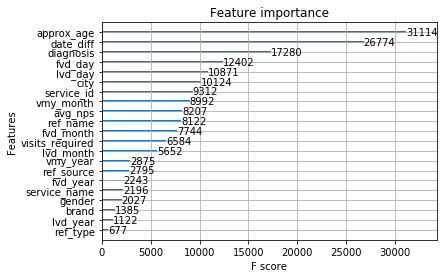

In [216]:
plot_importance(bst1)

### Submission

In [217]:
sub=pd.read_csv('Submission.csv')

In [219]:
ddtest=xgb.DMatrix(test[x_train.columns])
test['pred']=bst1.predict(ddtest)

In [220]:
temp=test.groupby(['patient_id'])['pred'].mean().reset_index()
temp.head()

,patient_id,pred
0,122,25457.578125
1,129,8341.695312
2,10251,5434.611816
3,10496,35580.003906
4,10701,31511.591797


In [221]:
sub.rename(index=str,columns={"PID":"patient_id","Bucket":'Bucket'},inplace=True)

In [222]:

sub=pd.merge(sub,temp,on='patient_id')

In [223]:
def buc(x):
    if x<=1000:
        return 'Low'
    elif x>1000 and x<=5000:
        return 'Med'
    elif x>5000 and x<=10000:
        return 'High-Med'
    elif x>10000:
        return 'High'

In [224]:
sub.Bucket=sub.pred.apply(lambda x : buc(x))
sub.drop('pred',axis=1,inplace=True)

,patient_id,Bucket,pred
0,111331,Low,458.745575
1,27477,Med,1368.923828
2,439072,Med,1628.417847
3,346329,Low,443.200745
4,58664,Low,523.833801


In [226]:
sub.rename(index=str,columns={"patient_id":"PID","Bucket":'Bucket'},inplace=True)
sub.head()

,PID,Bucket
0,111331,Low
1,27477,Med
2,439072,Med
3,346329,Low
4,58664,Low


In [227]:
sub.to_csv('sub-xgbt-new-1.csv',index=False)